* using data loaders and data sets

In [11]:
import numpy as np
import pandas as pd
import torch 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torch import nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.data as td


In [12]:
data = pd.read_csv('D:\OneDrive\MLprac\heart_disease_prediction.csv')
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [13]:
catcols = ['Smoking', 'AlcoholDrinking', 'Stroke',
        'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 
       'Asthma', 'KidneyDisease', 'SkinCancer']
data = pd.get_dummies(data, columns = catcols)
data['HeartDisease'] = LabelBinarizer().fit_transform(data['HeartDisease'])

In [14]:
x_train,x_test,y_train,y_test = train_test_split(data.drop('HeartDisease', axis = 1), data['HeartDisease'], test_size= 0.2, shuffle= True, stratify= data['HeartDisease'], random_state= 777)
x_train,x_val,y_train,y_val = train_test_split(x_train, y_train, test_size= 0.2, shuffle= True, stratify= y_train, random_state= 777)


In [15]:
data.head()

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,Stroke_No,...,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes
0,0,16.60,3.0,30.0,5.0,0,1,1,0,1,...,0,0,0,1,0,1,1,0,0,1
1,0,20.34,0.0,0.0,7.0,1,0,1,0,0,...,0,0,0,1,1,0,1,0,1,0
2,0,26.58,20.0,30.0,8.0,0,1,1,0,1,...,1,0,0,0,0,1,1,0,1,0
3,0,24.21,0.0,0.0,6.0,1,0,1,0,1,...,0,1,0,0,1,0,1,0,0,1
4,0,23.71,28.0,0.0,8.0,1,0,1,0,1,...,0,0,0,1,1,0,1,0,1,0


In [16]:
#building network
class HeartDiseaseNet(nn.Module):
    def __init__(self):
        super().__init__()
        hidden1 = nn.Linear(50,1024)
        relu1 = nn.ReLU()
        hidden2 = nn.Linear(1024,1024)
        relu2 = nn.ReLU()
        hidden3 = nn.Linear(1024,1024)
        relu3 = nn.ReLU()
        hidden4 = nn.Linear(1024,1)
        sigmoid = nn.Sigmoid()
        self.model = nn.Sequential(hidden1,relu1,hidden2,relu2,hidden3,relu3, hidden4, sigmoid)
    def forward(self,x):
        return self.model(x)

class HeartDiseaseDataSet(td.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self,idx):
        return (self.x.iloc[idx:idx+1,:].values.ravel(), self.y[idx:idx+1].values)

        

In [17]:
#preparing for training  
epochs = 250 # TRY MORE EPOCHS
batch_size = 32 # TRY SMALLER BATCH SIZE, POWERS OF 2
batch_count = x_train.shape[0]/batch_size if x_train.shape[0]%batch_size == 0 else (x_train.shape[0]//batch_size) + 1
learning_rate = 0.005 # TRY LOWER LEARNING RATE, 0.01, 0.001
loss_fn = nn.BCELoss() # loss for binary classification # Binary Cross Entropy
model = HeartDiseaseNet()
model = model.to(device = 'cuda')
optim = torch.optim.SGD(model.parameters(),lr = learning_rate)
traindata = HeartDiseaseDataSet(x_train, y_train)
train_data_loader = td.DataLoader(traindata,batch_size= batch_size, shuffle = True)

In [18]:
#training loop
epoc_hist = {'train_acc':[],'train_loss':[],'val_acc': [], 'val_loss': []}
for epoch in range(0,epochs): #epoch loop
    batch_acc = []
    batch_loss = []
    for idx, (x_batch, y_batch) in enumerate(train_data_loader): # batch loop
        probs = model.forward(x_batch.to(dtype = torch.float32, device = 'cuda'))
        loss = loss_fn(probs, y_batch.to(dtype = torch.float32, device = 'cuda'))
        optim.zero_grad() # resets the optimizer
        loss.backward() # doing first derivative (calc gradients)
        optim.step() # adjusting weights
        batch_loss.append(loss.item())
        batch_acc.append(accuracy_score(y_batch.cpu().detach().numpy(),[1 if prob > 0.5 else 0 for prob in probs.cpu().detach().numpy()]))
        #if idx%20 == 0:
            #print(f'batch {idx} loss: {batch_loss[-1]}, accuracy: {batch_acc[-1]}')
    epoc_hist['train_acc'].append(np.average(batch_acc))  
    epoc_hist['train_loss'].append(np.average(batch_loss))
    probs_val = model.forward(torch.from_numpy(x_val.values).to(dtype=torch.float32, device= 'cuda'))
    loss_val = loss_fn(probs_val, torch.from_numpy(y_val.values.reshape(-1,1)).to(dtype=torch.float32, device= 'cuda'))  
    epoc_hist['val_acc'].append(accuracy_score(y_val,[1 if prob > 0.5 else 0 for prob in probs_val.cpu().detach().numpy()])) 
    epoc_hist['val_loss'].append(loss_val.item())
    print(f'e({epoch}): T({epoc_hist["train_loss"][-1]},{epoc_hist["train_acc"][-1]}), V({epoc_hist["val_loss"][-1]},{epoc_hist["val_acc"][-1]})')

e(0): T(0.26491995851915234,0.9142956256142232), V(0.243168905377388,0.914712320200125)
e(1): T(0.2445543506765171,0.9148016617528812), V(0.23448556661605835,0.9160999061913696)
e(2): T(0.23959321877642478,0.915258141248995), V(0.23564651608467102,0.9158067542213884)
e(3): T(0.23641128416317023,0.9155645548557134), V(0.2345026433467865,0.9157285803627268)
e(4): T(0.23482354638167308,0.9151562360403824), V(0.22806888818740845,0.915650406504065)
e(5): T(0.23384062978342932,0.9156245812114715), V(0.2350223958492279,0.9154354283927455)
e(6): T(0.23273379991752438,0.9154940587867417), V(0.22793525457382202,0.91635397123202)
e(7): T(0.23211734949449792,0.9157320702671312), V(0.2268393337726593,0.9160999061913696)
e(8): T(0.23154691637454647,0.9155729306262842), V(0.2510829269886017,0.9115071919949969)
e(9): T(0.23128564999420767,0.9160063767533281), V(0.2298709899187088,0.9156113195747342)
e(10): T(0.23083188306782546,0.9158577068256947), V(0.22562967240810394,0.9162953408380238)
e(11): T(0.

<AxesSubplot:>

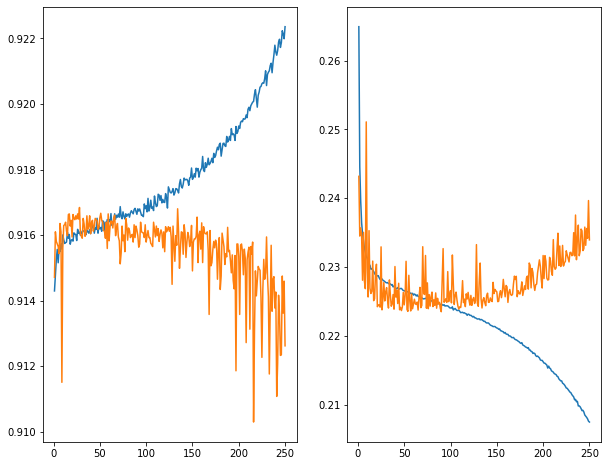

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,8))
sns.lineplot(x = range(1,epochs + 1), y = epoc_hist['train_acc'], ax = ax1)
sns.lineplot(x = range(1,epochs + 1), y = epoc_hist['val_acc'], ax = ax1)
sns.lineplot(x = range(1,epochs + 1), y = epoc_hist['train_loss'], ax = ax2)
sns.lineplot(x = range(1,epochs + 1), y = epoc_hist['val_loss'], ax = ax2)

In [20]:
with torch.no_grad():
    probs_test = model.forward(torch.from_numpy(x_test.values).to(dtype=torch.float32, device= 'cuda'))
    test_acc = accuracy_score(y_test,[1 if prob > 0.5 else 0 for prob in probs_test.cpu().detach().numpy()])
    print(f'test accuracy is {test_acc}')

test accuracy is 0.9125377194765396


In [10]:
torch.cuda.is_available()

True